## Apply an antenna pattern correction to the ALOS-2 PALSAR-2 images
- L1.5 imagery already has a generic radiometric correction applied, but there remains artefacts. This code applies an addition empirical radiometric correction.

**Inputs**
- stack of images that have already been speckle corrected, but before geocoding, to avoid the need to rotate the image (which could lead to data loss)

**Outputs**
- antenna pattern corrected data

**Method**
- calculate the rolling average of the backscatter across the image and plot this
- curve fit to the pattern
- find the central value
- reverse the curve fit - add the anomalies from the central value


In [ ]:
# %load 'imports.py'
# imports required for flood mapping code

import sys
import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(cmap_sequential='jet')
import matplotlib.pyplot as plt
import warnings
import netCDF4
import datetime
from calendar import monthrange
import pickle as pkl
from datetime import date, datetime, timedelta
import math
import seaborn as sns
import scipy
from scipy import stats

import warnings
# Image processing
import PIL 
from PIL import Image

# set plotting parameters
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Important to set this environment variable so that netcdf files can be opened.
%env HDF5_USE_FILE_LOCKING=FALSE

# Define input/output directories here



### Function declarations

In [3]:
def run_antenna_corrections(area, dates, pol, path_to_data):
    # input is a stack of images for the specified scene location and the list of image dates
    # output is an antenna pattern corrected stack of scenes
    print ('Dates this will be run for:')
    print (dates)
    
    # opening the data
    stack = xr.open_dataset(path_to_data + pol +'_SPK_' + area + '.nc')
    
    # a list of the variable names
    var_names = list(stack.keys())
    
    # the final var names are not images
    var_names = var_names[:-4]
    print (var_names)
    
    # masking water bodies
    # ALOS-2 PALSAR-2 L1.5 specific calibration factor
    calibration_factor = -83
    
    # calculating the antenna pattern correction for individual images within the stack
    # a holding array for the corrected data
    corrected_stack = []
    
    df_slopes = []
    df_intercepts = []
    
    # a holding array for the diference between the individual image linear regression y-value at the Eastern most
    # point, and the averaged slope linear regression y-value (which uses the original intercept value)
    # this difference is then added, so that the final regression applied to each image has the Eastern most values
    # matching their original ones.
    df_diffs = []
    
    for i in range(len(dates)):
        print ('Running the antenna correction for image ' + str(i+1) + ' in the stack of ' + str(len(var_names)) + ' images...')
        ds = stack[var_names[i]].to_dataset(name='Amplitude')
        
        # converting to db to apply a permanent water bodies threshold to the data
        # including permanent water bodies skews the antenna correction
        ds['Intensity'] = ds['Amplitude']**2
        ds['db'] = 10*np.log10(ds['Intensity']) + calibration_factor
        
        # applying the permanent water bodies threshold to the amplitude data (-11 dB)
        ds['Amplitude_masked'] = xr.where(ds['db']>-11, ds['Amplitude'], np.nan)
        
        # calculating the mean across all latitudes for each longitudinal pixel
        pattern_masked = np.mean(ds['Amplitude_masked'], axis=0)
        
        # converting to dataframe and changing the name 
        pm_df = pattern_masked.to_dataframe().reset_index().rename(columns = {'Amplitude_masked': 'Amplitude' })
        
        # Finding the mid-location of the image
        # the number of longitudinal points
        lon_points = len(pm_df)
        #mid_x = int(round(lon_points/2,0))
        # setting it to the point closest to the antenna
        mid_x = lon_points-1
        print (mid_x)
        
        # applying the corrections
        #df_corr, slope, intercept, df_mid = apply_antenna_pattern_correction(pm_df, mid_x)
        slope, intercept, df_mid = apply_antenna_pattern_correction(pm_df, mid_x)
        
        # appending the slopes and intercepts that will be used to calculate the final corrections
        df_slopes.append(slope)
        df_intercepts.append(intercept)
        
    # calculating the mean slope (this is better for multi-temporal analysis on a pixel by pixel basis)
    slope_mean = np.mean(df_slopes)
        
    print ('mean slope:' , str(np.round(slope_mean,3)))
    
    print ('Applying the final corrections using the mean slope...')
    for i in range(len(dates)):
        print ('image ' + str(i))
        
        # note mid_x is the Eastern most x value.
        df_diffs.append(df_slopes[i] * mid_x - slope_mean * mid_x)
        
        slope = slope_mean
        intercept = df_intercepts[i]
        df_mid = slope*mid_x + intercept + df_diffs[i]
        
        # original HH data
        ds = stack[var_names[i]].to_dataset(name = 'Amplitude')

        # use the same equations as in function to apply the linear regression line across the whole HH image 
        ds['regression'] = slope * ds['x'] + intercept + df_diffs[i]
        ds['anomaly'] = -ds['regression'] + df_mid
        ds['Amplitude_corrected'] = ds['Amplitude'] + ds['anomaly']
        
        # appending the corrected data to the new stack
        #corrected_stack.append(ds['Amplitude_corrected'].to_array("time", name=var_names[i]).to_dataset().assign_coords(time=all_dates[i]))
        corrected_stack.append(ds['Amplitude_corrected'].to_dataset(name = var_names[i]))

    return (stack, corrected_stack, var_names)


In [ ]:
def antenna_pattern_correction(df,ylim_min,ylim_max, txt):
    # function to correct and plot antenna pattern
    # returns a dataframe with the corrected values, the anomalies and the regression calculation
    # example usage: antenna_pattern_correction(po_df,4500,6500)
    p, ax1 = plt.subplots()
    p = sns.regplot(data=df[55:-55], x = 'x', y='Amplitude',scatter_kws={'s':1, 'color':'grey'}, scatter=True, label = 'uncorrected')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    p.set_ylim(ylim_min,ylim_max)
    p.set(title = (txt + ": Amplitude = " + str(round(slope,2))+'x + ' + str(round(intercept,2))))

    # now finding the regression amplitude values associated with the central longitude 
    df_mid = slope*mid_x + intercept

    print (df_mid)

    # creating a new anomaly column
    df['regression'] = slope*df['x'] + intercept
    df['anomaly'] = - df['regression'] + df_mid

    # adding this as an axis horizontal line
    p.axhline(df_mid, color='black', linestyle='--')

    # add the anomaly to the original values to get the final values
    df['Amplitude_corrected'] = df['Amplitude'] + df['anomaly']
    
    # adding the anomalies onto a second y-axis
    #ax2 = ax1.twinx()
    ax1.plot(df[55:-55]['x'],df[55:-55]['Amplitude_corrected'], color='red', label = 'corrected')
    ax1.legend(loc=3)
    #ax2.legend(loc=0)
    leg = ax1.legend(loc=0)
    leg.legendHandles[1]._sizes = [30]
    p.set_ylim(ylim_min,ylim_max)
    plt.show()

    return (df, slope, intercept, mid_x, df_mid)

In [4]:
def apply_antenna_pattern_correction(df, mid_x):
    # function to correct and plot antenna pattern
    # returns a dataframe with the corrected values, the anomalies and the regression calculation
    
    # subsetting the data to not include the edge pixels which have unreasonable values
    df = df[(df['x'] > 100) & (df['x'] < len(df) - 100)]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x = df['x'], y = df['Amplitude'])
    print (slope,intercept, r_value,p_value,std_err)
    print ("Amplitude = " + str(round(slope,2))+'x + ' + str(round(intercept,2)))

    # now finding the regression amplitude values associated with the Eastern most longitude
    # Use the central longitude if it's a Nadir pointing instrument
    # Otherwise use the side with the lowest incident angle
    
    # df_mid is the value of y (the backscatter amplitude at the longitudinal (x) position of mid_x)
    df_mid = slope*mid_x + intercept

    return (slope, intercept, df_mid)


In [5]:
def produce_corrected_stack(ds,array_ds,var_names):
    # takes the original formatted stack of images (ds1) and 
    # substitutes the data with the corrected images (array_ds)
    
    for i in range(len(array_ds)):
        ds[var_names[i]] = array_ds[i][var_names[i]]
    
    return ds

## Main code

### Assigning the arrays of image dates available for each scene area

In [6]:
# array of alos2 scene dates within each area
total_areas = 5

area1 = ['2021-11-24']
area2 = ['2019-03-29','2019-05-10','2019-06-21','2019-07-19','2019-08-30','2019-10-11','2019-11-22','2020-01-03','2020-02-14','2020-03-27','2020-05-08','2020-06-19','2020-07-17','2020-08-28','2020-10-09','2021-10-08','2021-11-19']
area3 = ['2020-09-06','2020-10-18','2020-11-29','2021-09-05','2021-10-17']
area4 = ['2020-08-28','2020-10-09','2021-10-08','2021-11-19']
area5 = ['2020-09-06','2020-10-18','2020-11-29','2021-09-05','2021-10-17','2021-11-28']

# declaring an array of lists of dates
all_dates = [area1, area2, area3, area4, area5]

# converting to the datetime format required for dataframes
#for i in range(len(all_dates)):
#    all_dates_dt[i] = pd.to_datetime(all_dates[i])

### Applying the corrections 
- 1. HH polarisation 
- 2. HV polarisation

In [ ]:
%%time
#%%capture --no-display

pol = 'HH'

for area_num in range(1,6):
    
    area = 'area' + str(area_num)
    print ('Running the corrections for area: ' + str(area_num) + ' and pol: ' + pol)
    # area2 dates
    dates = all_dates[area_num - 1]

    path_to_data = ALOS_OUT_NEW + 'SPK_nc/'

    ds, array_ds, var_names = run_antenna_corrections(area, dates, pol, path_to_data)

    ds_corr = produce_corrected_stack(ds, array_ds,var_names)
    ds_corr

    # saving to netcdf
    ds_corr.to_netcdf(ALOS_OUT_NEW + '/SPK_nc3/' + pol + '_' + area + '_corrected.nc')

In [ ]:
%%time
#%%capture --no-display

pol = 'HV'

for area_num in range(1,6):
    
    area = 'area' + str(area_num)
    print ('Running the corrections for area: ' + str(area_num) + ' and pol: ' + pol)
    # area2 dates
    dates = all_dates[area_num - 1]

    path_to_data = ALOS_OUT_NEW + 'SPK_nc/'

    ds, array_ds, var_names = run_antenna_corrections(area, dates, pol, path_to_data)

    ds_corr = produce_corrected_stack(ds, array_ds,var_names)
    ds_corr

    # saving to netcdf
    ds_corr.to_netcdf(ALOS_OUT_NEW + '/SPK_nc3/' + pol + '_' + area + '_corrected.nc')

### Final notes
- Use of the mean linear regression has now been implemented within the above functions
- This enables consistency in pixel-to-pixel timeseries analysis as the slope of the correction will now be the same for all time steps. 
- next code: Collocate_antenna_corrected_outputs.ipynb 
- The final geocoding processing step can be carried out in SNAP or using the snappy python interface

### Quick comparison between antenna pattern corrected and uncorrected images

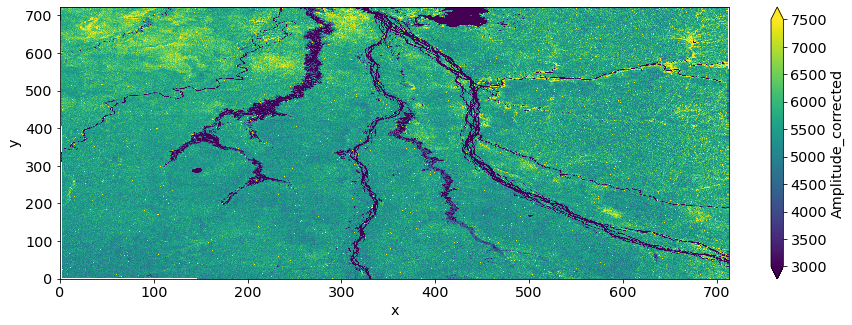

In [280]:
# corrected - more balanced distribution of backscatter
ds['Amplitude_corrected'][::20,::20].plot(vmin = 3000, vmax=7500, cmap='viridis')